**P7 PROJECT: Problematic subgroup research on textual data**

Metodology application on IMBD DATASET

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, set_seed
import torch
from torch.utils.data import Dataset
import numpy as np
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import spacy
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

In [ ]:
# set seeds for reproducibility
def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

set_global_seed(42)

In [ ]:
# nltk stopwords
nltk.download('stopwords')
nltk.download('punkt')

# spacy model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**STEP ONE**
Dataset loading, preprocessing and predictions

In [ ]:
df = pd.read_csv('10K_tweets_text_label.csv')
df.head()

,text,label
0,plus you've added commercials to the experienc...,1
1,"it's really aggressive to blast obnoxious ""ent...",0
2,and it's a really big bad thing about it,0
3,seriously would pay $30 a flight for seats tha...,0
4,"yes, nearly every time I fly VX this “ear worm...",1


In [ ]:
# Preprocessing
# Remove numbers, Convert text to lowercase, Remove URLs, Remove punctuation,
# Tokenize text, Remove stopwords, Reconstruct text, Lemmatize text, Remove extra whitespace
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    text = ' '.join(words)
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    text = ' '.join(text.split())
    return text
df['preprocessed_text'] = df['text'].apply(preprocess_text)

In [ ]:
#test train spleet
X_train, X_test, y_train, y_test = train_test_split(df[['text', 'preprocessed_text']], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode data
def encode_data(texts, tokenizer, max_length=512):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Tokenize and encode data
train_encodings = encode_data(X_train['preprocessed_text'], tokenizer)
test_encodings = encode_data(X_test['preprocessed_text'], tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#define class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

y_train_encoded = y_train.tolist()
y_test_encoded = y_test.tolist()

#create encoded datasets
train_dataset = TweetDataset(train_encodings, y_train_encoded)
test_dataset = TweetDataset(test_encodings, y_test_encoded)

In [ ]:
!pip install accelerate -U

In [ ]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# training parameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    seed=42,
    learning_rate=1e-6,
    save_total_limit=1,
    load_best_model_at_end=True
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the modeld
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.430800,0.329529
2,0.268100,0.271345
3,0.344300,0.280069


TrainOutput(global_step=3000, training_loss=0.3474684513807297, metrics={'train_runtime': 386.8012, 'train_samples_per_second': 62.047, 'train_steps_per_second': 7.756, 'total_flos': 456333236640000.0, 'train_loss': 0.3474684513807297, 'epoch': 3.0})

In [ ]:
#get predictions
predictions = trainer.predict(test_dataset)
predicted_probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

In [ ]:
#add predictions and their probability on test dataset
pred_labels = predictions.predictions.argmax(axis=1)
pred_probs = predicted_probs.max(dim=1).values
# new dataframe with: original data, the prediction and the probability for the test set
df = pd.DataFrame({
    'text': X_test['text'],
    'preprocessed_text': X_test['preprocessed_text'],
    'label': y_test.tolist(),
    'prediction': pred_labels.tolist(),
    'probability': pred_probs.tolist()
})
df['probability'] = df['probability'].round(2)
df.head()

,text,preprocessed_text,label,prediction,probability
6252,You mean take more of my time to write you a p...,mean take time write physical letter fraud dep...,0,0,0.99
4684,Incredibly frustrating. I emailed but still ha...,incredibly frustrating email still have not re...,0,0,0.98
1731,"Yeah, I tried that about 10 times for two diff...",yeah try time two different ticket tell try la...,0,0,0.99
4742,you guys are so clever 😃 http://t.co/qn5odUGFqK,guy clever httptcoqnodugfqk,1,1,0.67
4521,Another delay. Wow,another delay wow,0,0,0.83


**STEP TWO**
p* research and metadata addition

In [ ]:
!pip install datasets
!pip install datasets nltk spacy scikit-learn textstat
!pip install spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00


In [ ]:
import random
import nltk
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat import flesch_reading_ease
import string
from textstat.textstat import textstatistics
from sklearn.preprocessing import MinMaxScaler

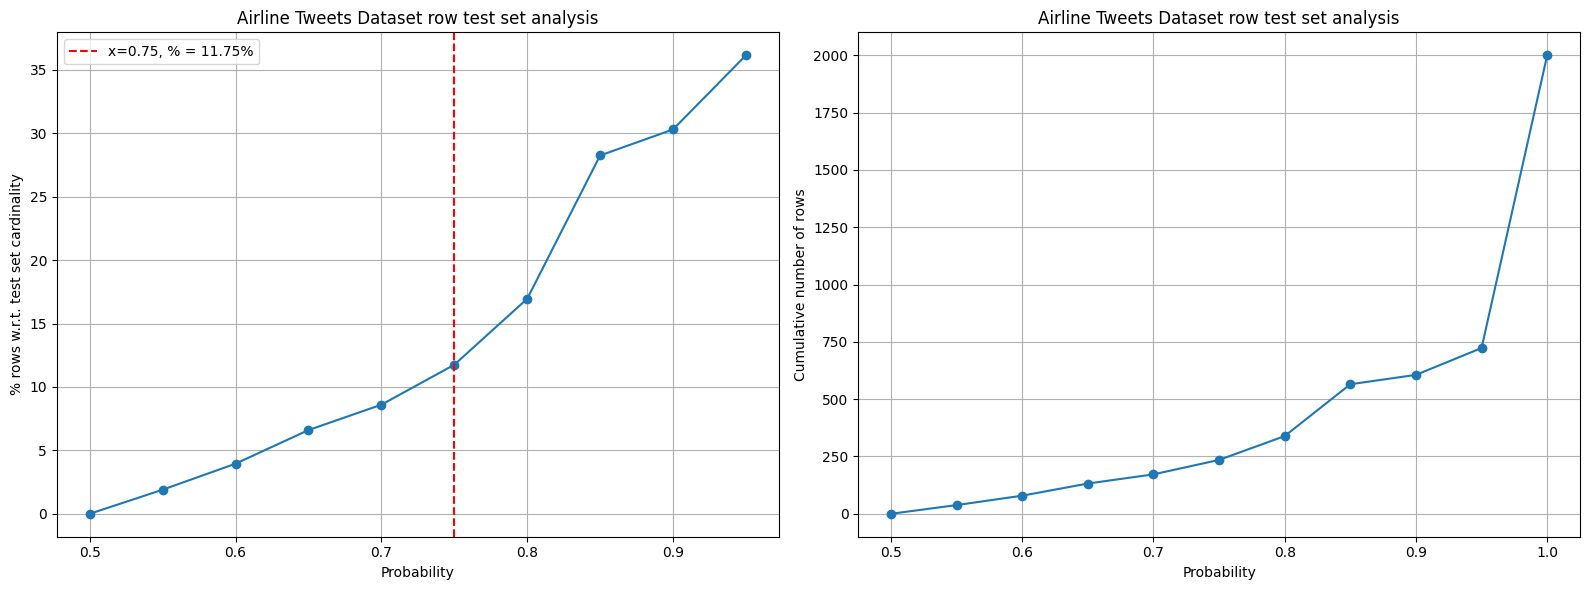

Percentuale di righe per x=0.75: 11.75%


In [ ]:
# % of rows
x_percentuale = np.arange(0.5, 1, 0.05)
y_percentuale = np.zeros(len(x_percentuale))
for i in range(len(x_percentuale)):
    y_percentuale[i] = ((df['probability'] <= x_percentuale[i]).sum() / len(df)) * 100  # Calcolo della percentuale

# number of rows
x_numero = np.arange(0.5, 1.05, 0.05)
y_numero = np.zeros(len(x_numero), dtype=int)
for i in range(len(x_numero)):
    y_numero[i] = (df['probability'] <= x_numero[i]).sum()  # Calcolo del numero di righe

# create graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graph 1: % of rows per probability interval
ax1.plot(x_percentuale, y_percentuale, marker='o', linestyle='-')
ax1.set_xlabel('Probability')
ax1.set_ylabel('% rows w.r.t. test set cardinality')
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.set_title('Airline Tweets Dataset row test set analysis')

# index closer to 0.6
indice_x_07 = np.abs(x_percentuale - 0.75).argmin()
percentuale_x_07 = y_percentuale[indice_x_07]
ax1.axvline(x=x_percentuale[indice_x_07], color='red', linestyle='--', label=f'x=0.75, % = {percentuale_x_07:.2f}%')
ax1.legend()

# Graph 2: number of rows per probabiity interval
ax2.plot(x_numero, y_numero, marker='o', linestyle='-')
ax2.set_xlabel('Probability')
ax2.set_ylabel('Cumulative number of rows')
ax2.tick_params(axis='y')
ax2.grid(True)
ax2.set_title('Airline Tweets Dataset row test set analysis')




fig.tight_layout()
plt.show()

print(f"Percentuale di righe per x=0.75: {percentuale_x_07:.2f}%")

In [ ]:
df = pd.read_csv('10K_predictions_with_preprocessed_text_prob2.csv')

The dataset contains movie reviews and related sentiment (positive = 1 and negative = 0).

Starting from these 10 thousand reviews, we want to build a dataframe with features given by some statistics

Let's start with features generated from statistics, we will have:


* words: number of words
* num_chars: number of characters
* sentences: number of sentences
* avg_word_length: average word length
* avg_sentence_length: average sentence length
* num_excl: number of exclamation marks
* num_quest: number of question marks
* periods: number of periods
* uppercase: number of uppercase words
* NER: number of named entities
* readability: readability score
* TF-IDF(20): Term frequency-inverse document frequency for specific words

In [ ]:
# Load the spaCy model for named entity recognition
nlp = spacy.load("en_core_web_sm")
#import textstat library
from textstat import flesch_reading_ease
from textstat.textstat import textstatistics

# Function to count the number of words
def count_words(text):
    if pd.isnull(text):
        return 0
    return len(text.split())

# Function to count the number of characters
def count_chars(text):
    if pd.isnull(text):
        return 0
    return len(text)

# Function to count the number of sentences
def count_sentences(text):
    if pd.isnull(text):
        return 0
    return len(text.split('.'))

# Function to calculate the average word length
def avg_word_length(text):
    if pd.isnull(text):
        return 0
    words = text.split()
    return sum(len(word) for word in words) / len(words) if words else 0

# Function to calculate the average sentence length
def avg_sentence_length(text):
    if pd.isnull(text):
        return 0
    sentences = text.split('.')
    words = text.split()
    return len(words) / len(sentences) if sentences else 0

# Function to count the number of exclamation marks
def count_excl(text):
    if pd.isnull(text):
        return 0
    return sum(1 for char in text if char in '!')

# Function to count the number of questions marks
def count_quest(text):
    if pd.isnull(text):
        return 0
    return sum(1 for char in text if char in '?')

# Function to count the number of periods
def count_periods(text):
    if pd.isnull(text):
        return 0
    return sum(1 for char in text if char in '.')


# Function to count the number of uppercase words
def count_uppercase(text):
    if pd.isnull(text):
        return 0
    return sum(1 for word in text if word.isupper())


# Function to count the number of named entities
def count_ner(text):
    if pd.isnull(text):
        return 0
    doc = nlp(text)
    return len(doc.ents)

# Function to calculate the readability score
def readability_score(text):
    if pd.isnull(text):
        return 0
    return textstatistics().flesch_reading_ease(text)


# Apply the functions to create new columns
df['num_words'] = df['text'].apply(count_words)
df['num_chars'] = df['text'].apply(count_chars)
df['sentences'] = df['text'].apply(count_sentences)
df['avg_word_length'] = df['text'].apply(avg_word_length).round(2)
df['avg_sentence_length'] = df['text'].apply(avg_sentence_length).round(2)
df['num_excl'] = df['text'].apply(count_excl).round(2)
df['num_quest'] = df['text'].apply(count_quest).round(2)
df['num_period'] = df['text'].apply(count_periods).round(2)
df['num_upperCase'] = df['text'].apply(count_uppercase).round(2)
df['NER'] = df['text'].apply(count_ner).round(2)
df['readability'] = df['text'].apply(readability_score).round(2)

df.head()


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,text,preprocessed_text,label,prediction,probability,num_words,num_chars,sentences,avg_word_length,avg_sentence_length,num_excl,num_quest,num_period,num_upperCase,NER,readability
6252,You mean take more of my time to write you a p...,mean take time write physical letter fraud dep...,0,0,0.99,23,130,2,4.70,11.50,0,1,1,2,1,73.51
4684,Incredibly frustrating. I emailed but still ha...,incredibly frustrating email still have not re...,0,0,0.98,10,72,3,6.30,3.33,0,0,2,2,0,52.87
1731,"Yeah, I tried that about 10 times for two diff...",yeah try time two different ticket tell try la...,0,0,0.99,20,104,2,4.25,10.00,0,0,1,5,2,85.02
4742,you guys are so clever 😃 http://t.co/qn5odUGFqK,guy clever httptcoqnodugfqk,1,1,0.67,7,47,2,5.86,3.50,0,0,1,4,0,73.85
4521,Another delay. Wow,another delay wow,0,0,0.83,3,18,2,5.33,1.50,0,0,1,2,0,34.59


In [ ]:
#FOR TF-IDF
# List of selected words
selected_words = [
    "love", "great", "excellent", "amazing", "awesome", "fantastic", "enjoyed", "best",
    "wonderful", "favorite", "bad", "worst", "boring", "terrible", "awful",
    "disappointing", "waste", "poor", "hate", "mediocre"
]

# Initialize the TfidfVectorizer with the selected words as vocabulary
vectorizer = TfidfVectorizer(vocabulary=selected_words)

# Fit and transform the 'text' column
tfidf_matrix = vectorizer.fit_transform(df['text'].fillna(""))

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Add the TF-IDF columns to the original DataFrame
df = pd.concat([df, tfidf_df], axis=1)
# Function to count occurrences of each word in the text column
def count_word_occurrences(word, text_series):
    return text_series.str.contains(f'\\b{word}\\b', case=False, na=False).sum()

# Create a dictionary to store the counts
word_counts = {word: count_word_occurrences(word, df['text']) for word in selected_words}

# Display the counts
for word, count in word_counts.items():
    print(f"'{word}' appears in {count} rows")


'love' appears in 39 rows
'great' appears in 51 rows
'excellent' appears in 4 rows
'amazing' appears in 20 rows
'awesome' appears in 19 rows
'fantastic' appears in 6 rows
'enjoyed' appears in 1 rows
'best' appears in 26 rows
'wonderful' appears in 5 rows
'favorite' appears in 2 rows
'bad' appears in 26 rows
'worst' appears in 38 rows
'boring' appears in 0 rows
'terrible' appears in 19 rows
'awful' appears in 7 rows
'disappointing' appears in 2 rows
'waste' appears in 1 rows
'poor' appears in 14 rows
'hate' appears in 8 rows
'mediocre' appears in 0 rows


In [ ]:
# Add 'uncertainty' feature
df['uncertainty'] = (df['probability'] <= 0.7).astype(int)

In [ ]:

column_order = ['text', 'num_words', 'num_chars', 'sentences', 'avg_word_length', 'avg_sentence_length', 'num_upperCase',
                'num_excl','num_quest','num_period','NER', 'readability'] + selected_words + ['prediction', 'probability', 'uncertainty', 'label']
df = df[column_order]
df.head(5)

,text,num_words,num_chars,sentences,avg_word_length,avg_sentence_length,num_upperCase,num_excl,num_quest,num_period,...,awful,disappointing,waste,poor,hate,mediocre,prediction,probability,uncertainty,label
6252,You mean take more of my time to write you a p...,23.0,130.0,2.0,4.70,11.50,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.99,0,0.0
4684,Incredibly frustrating. I emailed but still ha...,10.0,72.0,3.0,6.30,3.33,2.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.98,0,0.0
1731,"Yeah, I tried that about 10 times for two diff...",20.0,104.0,2.0,4.25,10.00,5.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0,0.0
4742,you guys are so clever 😃 http://t.co/qn5odUGFqK,7.0,47.0,2.0,5.86,3.50,4.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.67,1,1.0
4521,Another delay. Wow,3.0,18.0,2.0,5.33,1.50,2.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.83,0,0.0


In [ ]:
df.to_csv("2K_film_metatdata_and_uncertainty_to_preprocess_and_DivExp.csv", index = False)

**STEP THREE** Data discretization and DivExplorer

In [ ]:
df = pd.read_csv('2K_film_metatdata_and_uncertainty_to_preprocess_and_DivExp.csv')

In [ ]:
valori_univoci = df['uncertainty'].unique()
print(valori_univoci)

[0 1]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#scaling tf-idf and readability
features_to_scale = [
    "love", "great", "excellent", "amazing", "awesome", "fantastic", "enjoyed", "best",
    "wonderful", "favorite", "bad", "worst", "boring", "terrible", "awful",
    "disappointing", "waste", "poor", "hate","mediocre"

]

#create MinMaxScaler object
scaler = MinMaxScaler()

# scale selected columnns
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df[features_to_scale] = df[features_to_scale].applymap(lambda x: round(x, 2))



print("Scaled dataframe:")
print(df.head(2))

Scaled dataframe:
                                                   text  num_words  num_chars  \
6252  You mean take more of my time to write you a p...       23.0      130.0   
4684  Incredibly frustrating. I emailed but still ha...       10.0       72.0   

      sentences  avg_word_length  avg_sentence_length  num_upperCase  \
6252        2.0              4.7                11.50            2.0   
4684        3.0              6.3                 3.33            2.0   

      num_excl  num_quest  num_period  ...  awful  disappointing  waste  poor  \
6252       0.0        1.0         1.0  ...    NaN            NaN    NaN   NaN   
4684       0.0        0.0         2.0  ...    NaN            NaN    NaN   NaN   

      hate  mediocre  prediction  probability  uncertainty  label  
6252   NaN       NaN         0.0         0.99            0    0.0  
4684   NaN       NaN         0.0         0.98            0    0.0  

[2 rows x 36 columns]


feature discretization

In [ ]:
# num_words
max_min_values = df['num_words'].agg(['max', 'min'])

print("Valori massimi e minimi di ogni colonna:")
print(max_min_values)
#discretization
bins = [1,7,15,23,31]
labels = ['very short', 'short', 'long', 'very long']
df['#words'] = pd.cut(df['num_words'], bins=bins, labels=labels)
df.drop(columns=['num_words'], inplace=True)

print("Dataframe con la feature discretizzata:")
print(df.head(3))

Valori massimi e minimi di ogni colonna:
max    31.0
min     1.0
Name: num_words, dtype: float64
Dataframe con la feature discretizzata:
                                                   text  num_chars  sentences  \
6252  You mean take more of my time to write you a p...      130.0        2.0   
4684  Incredibly frustrating. I emailed but still ha...       72.0        3.0   
1731  Yeah, I tried that about 10 times for two diff...      104.0        2.0   

      avg_word_length  avg_sentence_length  num_upperCase  num_excl  \
6252             4.70                11.50            2.0       0.0   
4684             6.30                 3.33            2.0       0.0   
1731             4.25                10.00            5.0       0.0   

      num_quest  num_period  NER  ...  disappointing  waste  poor  hate  \
6252        1.0         1.0  1.0  ...            NaN    NaN   NaN   NaN   
4684        0.0         2.0  0.0  ...            NaN    NaN   NaN   NaN   
1731        0.0         1.0 

In [ ]:
#similar for the other features

#num_chars
bins = [4, 42, 80, 118, 157]
labels = ['very short', 'short', 'long', 'very long']
df['#chars'] = pd.cut(df['num_chars'], bins=bins, labels=labels)
df.drop(columns=['num_chars'], inplace=True)

#sentences
bins = [1, 3, 5, 7, 10]
labels = ['very short', 'short', 'long', 'very long']
df['#_sent'] = pd.cut(df['sentences'], bins=bins, labels=labels)
df.drop(columns=['sentences'], inplace=True)

#avg_word_lenght
bins = [3, 6, 9, 12, 16]
labels = ['very short', 'short', 'long', 'very long']
df['avg_w_l'] = pd.cut(df['avg_word_length'], bins=bins, labels=labels)
df.drop(columns=['avg_word_length'], inplace=True)

#avg_sentence_lenght
bins = [1, 7, 15, 23, 31]
labels = ['very short', 'short', 'long', 'very long']
df['avg_s_l'] = pd.cut(df['avg_sentence_length'], bins=bins, labels=labels)
df.drop(columns=['avg_sentence_length'], inplace=True)

#num uppercase
bins = [0, 15, 30, 45, 60]
labels = ['very short', 'short', 'long', 'very long']
df['#upperCase'] = pd.cut(df['num_upperCase'], bins=bins, labels=labels)
df.drop(columns=['num_upperCase'], inplace=True)

#num excl
bins = [1, 3, 5, 7, 10]
labels = ['very short', 'short', 'long', 'very long']
df['#_excl'] = pd.cut(df['num_excl'], bins=bins, labels=labels, right=False)
df.drop(columns=['num_excl'], inplace=True)

#num quest
bins = [0, 3, 6, 9, 11]
labels = ['very short', 'short', 'long', 'very long']
df['#_quest'] = pd.cut(df['num_quest'], bins=bins, labels=labels, right=False)
df.drop(columns=['num_quest'], inplace=True)

#num periods
bins = [0, 2, 4, 6, 9]
labels = ['very short', 'short', 'long', 'very long']
df['#_periods'] = pd.cut(df['num_period'], bins=bins, labels=labels, right=False)
df.drop(columns=['num_period'], inplace=True)

#NER
bins = [0, 2, 4, 6, 8]
labels = ['very short', 'short', 'long', 'very long']
df['#_NER'] = pd.cut(df['NER'], bins=bins, labels=labels, right=False)
df.drop(columns=['NER'], inplace=True)




In [ ]:
!pip install divexplorer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.9 MB/s eta 0:00:00


In [ ]:
list_ = ['text', 'love', 'great', 'excellent', 'amazing', 'awesome', 'fantastic', 'enjoyed', 'best', 'wonderful', 'probability', 'prediction',  'favorite', 'bad', 'worst', 'boring', 'terrible', 'awful', 'disappointing', 'waste', 'poor', 'hate', 'mediocre', 'label']
df.drop(columns=list_, inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
from divexplorer import DivergenceExplorer
fp_diver = DivergenceExplorer(df)
#attributes = ['avg_s_l', '#chars', '#_sent', '#_punct', '#NER', 'readability_']
subgroups = fp_diver.get_pattern_divergence(min_support=0.1,  boolean_outcomes=["uncertainty"])
subgroups = subgroups.sort_values(by="uncertainty_div", ascending=False, ignore_index=True)
subgroups.head(10)

,support,itemset,uncertainty,uncertainty_div,uncertainty_t,length,support_count
0,0.166295,"(#_quest=very short, #_NER=very short, avg_s_l=very short)",0.134003,0.086092,6.041686,3,597.0
1,0.166852,"(avg_s_l=very short, #_NER=very short)",0.133556,0.085645,6.027801,2,599.0
2,0.137604,"(#_quest=very short, #_NER=very short, avg_s_l=very short, #upperCase=very short)",0.131579,0.083668,5.425644,4,494.0
3,0.138162,"(avg_s_l=very short, #_NER=very short, #upperCase=very short)",0.131048,0.083138,5.410493,3,496.0
4,0.105850,"(#upperCase=very short, avg_s_l=very short, #_quest=very short, #_sent=very short)",0.126316,0.078405,4.589224,4,380.0
5,0.106128,"(#upperCase=very short, avg_s_l=very short, #_sent=very short)",0.125984,0.078073,4.580641,3,381.0
6,0.114206,"(avg_s_l=very short, #_quest=very short, #_sent=very short)",0.124390,0.076479,4.666192,3,410.0
7,0.107521,(#chars=short),0.124352,0.076441,4.537853,1,386.0
8,0.114763,"(avg_s_l=very short, #_sent=very short)",0.123786,0.075876,4.649609,2,412.0
9,0.105850,"(#chars=short, #_quest=very short)",0.123684,0.075773,4.476877,2,380.0


In [ ]:
from divexplorer import DivergencePatternProcessor
fp_details = DivergencePatternProcessor(subgroups, 'uncertainty')

# We can pick a pattern
pattern = fp_details.patterns['itemset'].iloc[0]
print(pattern)

# and compute the Shapley value of the items.
sv = fp_details.shapley_value(pattern)
sv

frozenset({'#_quest=very short', '#_NER=very short', 'avg_s_l=very short'})


{frozenset({'#_quest=very short'}): 0.013334585684747347,
 frozenset({'#_NER=very short'}): 0.02329288591835305,
 frozenset({'avg_s_l=very short'}): 0.04946501497090239}

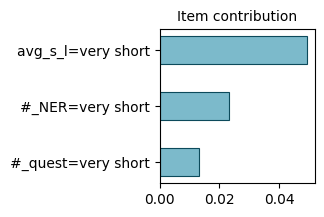

In [ ]:
fp_details.plot_shapley_value(pattern = pattern, figsize=(2,2), title="Item contribution")